# Events

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
from discontinuitypy.datasets import IDsDataset
from beforerr.polars import pl_norm

from sunpy.time import TimeRange
from datetime import timedelta
from space_analysis.utils.speasy import Variables

from typing import Literal

from pydantic import BaseModel

21-Feb-24 15:23:40: UserWarning: Traceback (most recent call last):
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
    from . import skintegrate
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/skintegrate.py", line 20, in <module>
    from sklearn.base import BaseEstimator
ModuleNotFoundError: No module named 'sklearn'


21-Feb-24 15:23:40: UserWarning: pdpipe: Scikit-learn or skutil import failed. Scikit-learn-dependent pipeline stages will not be loaded.

21-Feb-24 15:23:40: UserWarning: Traceback (most recent call last):
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 105, in <module>
    from . import nltk_stages
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/nltk_stages.py", line 19, in <module>
    import nltk
ModuleNotFoundError: No module named 'nltk'


21-Feb-2

In [3]:
enc = "enc2"
# enc = "enc4"

In [50]:
AvailableInstrs = Literal["spi", "spc", "sqtn", "qtn"]

class Config(BaseModel):
    
    instr_p: AvailableInstrs = "spc"
    instr_p_den: AvailableInstrs = "sqtn"
    
    mag_dataset: str = "PSP_FLD_L2_MAG_RTN"
    mag_parameters: list[str] = ["psp_fld_l2_mag_RTN"]
    
    fmt: str = 'arrow'
    
config = Config(
    instr_p="spi",
    instr_p_den="spi",
)

In [51]:
dir = "../data"

tau = timedelta(seconds=16)
ts = timedelta(seconds=1 / 180)

psp_p_instr = config.instr_p
instr_p_den = config.instr_p_den
mag_dataset = config.mag_dataset
mag_parameters = config.mag_parameters

In [52]:
match enc:
    case "enc2": # Encounter 2
        start = "2019-04-07T01:00"
        end = "2019-04-07T12:00"

        earth_start = "2019-04-09"
        earth_end = "2019-04-12"

    case "enc4": # Encounter 4
        start = '2020-01-27'
        end = '2020-01-29'

        earth_start = '2020-01-29'
        earth_end = '2020-01-31'

Q: What is the time scale for change in magnetic field, density and velocity?

- Different dataset comes with different time resolution.
- Mangnetic field data has the highest time resolution.

method 1: directly interpolate density and velocity into magnetic field data respectively
method 2: interpolate density into velocity data first

In [55]:
psp_timerange = TimeRange(start, end)
earth_timerange = TimeRange(earth_start, earth_end)

In [56]:
def validate(timerange):
    if isinstance(timerange, TimeRange):
        return [timerange.start.to_string(), timerange.end.to_string()]

In [57]:
timerange = validate(psp_timerange)

p_vars = Variables(timerange=timerange)

match psp_p_instr:
    case "spi":
        p_vars.dataset = "PSP_SWP_SPI_SF00_L3_MOM"
        p_vars.parameters = ["VEL_RTN_SUN", "TEMP", "SUN_DIST"]
    case "spc":
        p_vars.dataset = "PSP_SWP_SPC_L3I"
        p_vars.parameters = ["vp_moment_RTN_gd", "wp_moment_gd"]

match instr_p_den:
    case "sqtn":
        den_product = "cda/PSP_FLD_L3_SQTN_RFS_V1V2/electron_density"
    case "qtn":
        den_product = "cda/PSP_FLD_L3_RFS_LFR_QTN/N_elec"
    case "spc":
        den_product = "cda/PSP_SWP_SPC_L3I/np_moment_gd"
        # np_fit_gd
    case "spi":
        den_product = "cda/PSP_SWP_SPI_SF00_L3_MOM/DENS"

p_vars.check_products()
p_vars.products.insert(0, den_product)

fname =  f"{dir}/psp_ids_dataset_{enc}_{psp_p_instr}_n_{instr_p_den}.{config.fmt}"

#### Check Different Density Product 

Time resolution (from high to low): SPC, SPI, SQTN, QTN
Quality (fluctuating, from high to low): SQTN, QTN, SPC/SPI

So we use `SQTN` dataset for density variables.

statistic,time,Electron density,delta,delta (clean)
str,str,f64,str,str
"""count""","""4556""",1710.0,"""4555""","""1709"""
"""null_count""","""0""",2846.0,"""1""","""1"""
"""mean""","""2019-04-07 06:…",132.656687,"""0:00:08.680221…","""0:00:23.053596…"
"""std""",null,12.713958,null,null
"""min""","""2019-04-07 01:…",118.103043,"""0:00:06.881103…","""0:00:06.935791…"
"""25%""","""2019-04-07 04:…",118.103043,"""0:00:06.990478…","""0:00:06.990478…"
"""50%""","""2019-04-07 06:…",132.683655,"""0:00:06.990478…","""0:00:06.990478…"
"""75%""","""2019-04-07 09:…",132.683655,"""0:00:06.990722…","""0:00:13.981201…"
"""max""","""2019-04-07 11:…",164.388046,"""0:02:26.801033…","""0:06:52.440940…"


statistic,time,electron density,delta,delta (clean)
str,str,f64,str,str
"""count""","""5665""",2849.0,"""5664""","""2848"""
"""null_count""","""0""",2816.0,"""1""","""1"""
"""mean""","""2019-04-07 06:…",150.920486,"""0:00:06.990524…","""0:00:13.877958…"
"""std""",null,16.268038,null,null
"""min""","""2019-04-07 01:…",111.762695,"""0:00:06.881103…","""0:00:06.935791…"
"""25%""","""2019-04-07 03:…",141.061813,"""0:00:06.990478…","""0:00:06.990478…"
"""50%""","""2019-04-07 06:…",152.215729,"""0:00:06.990478…","""0:00:06.990723…"
"""75%""","""2019-04-07 09:…",156.988998,"""0:00:06.990479…","""0:00:13.981201…"
"""max""","""2019-04-07 11:…",208.122925,"""0:00:07.099609…","""0:02:19.810554…"


statistic,time,np_moment,delta,delta (clean)
str,str,f64,str,str
"""count""","""180008""",88028.0,"""180007""","""88027"""
"""null_count""","""0""",91980.0,"""1""","""1"""
"""mean""","""2019-04-07 06:…",118.729671,"""0:00:00.219990…","""0:00:00.449549…"
"""std""",null,28.521138,null,null
"""min""","""2019-04-07 01:…",4.567824,"""0:00:00.218419…","""0:00:00.218419…"
"""25%""","""2019-04-07 03:…",99.79612,"""0:00:00.218440…","""0:00:00.218440…"
"""50%""","""2019-04-07 06:…",114.158913,"""0:00:00.218459…","""0:00:00.218460…"
"""75%""","""2019-04-07 09:…",132.282745,"""0:00:00.218460…","""0:00:00.218460…"
"""max""","""2019-04-07 11:…",334.422333,"""0:01:09.031423…","""0:03:37.143172…"


statistic,time,Density,delta,delta (clean)
str,str,f64,str,str
"""count""","""5657""",5657.0,"""5656""","""5656"""
"""null_count""","""0""",0.0,"""1""","""1"""
"""mean""","""2019-04-07 06:…",94.784693,"""0:00:07.000412…","""0:00:07.000412…"
"""std""",null,29.243105,null,null
"""min""","""2019-04-07 01:…",6.875667,"""0:00:06.116700…","""0:00:06.116700…"
"""25%""","""2019-04-07 03:…",78.027466,"""0:00:06.990480…","""0:00:06.990480…"
"""50%""","""2019-04-07 06:…",98.384621,"""0:00:06.990540…","""0:00:06.990540…"
"""75%""","""2019-04-07 09:…",116.409706,"""0:00:06.990540…","""0:00:06.990540…"
"""max""","""2019-04-07 11:…",159.338196,"""0:01:03.788583…","""0:01:03.788583…"


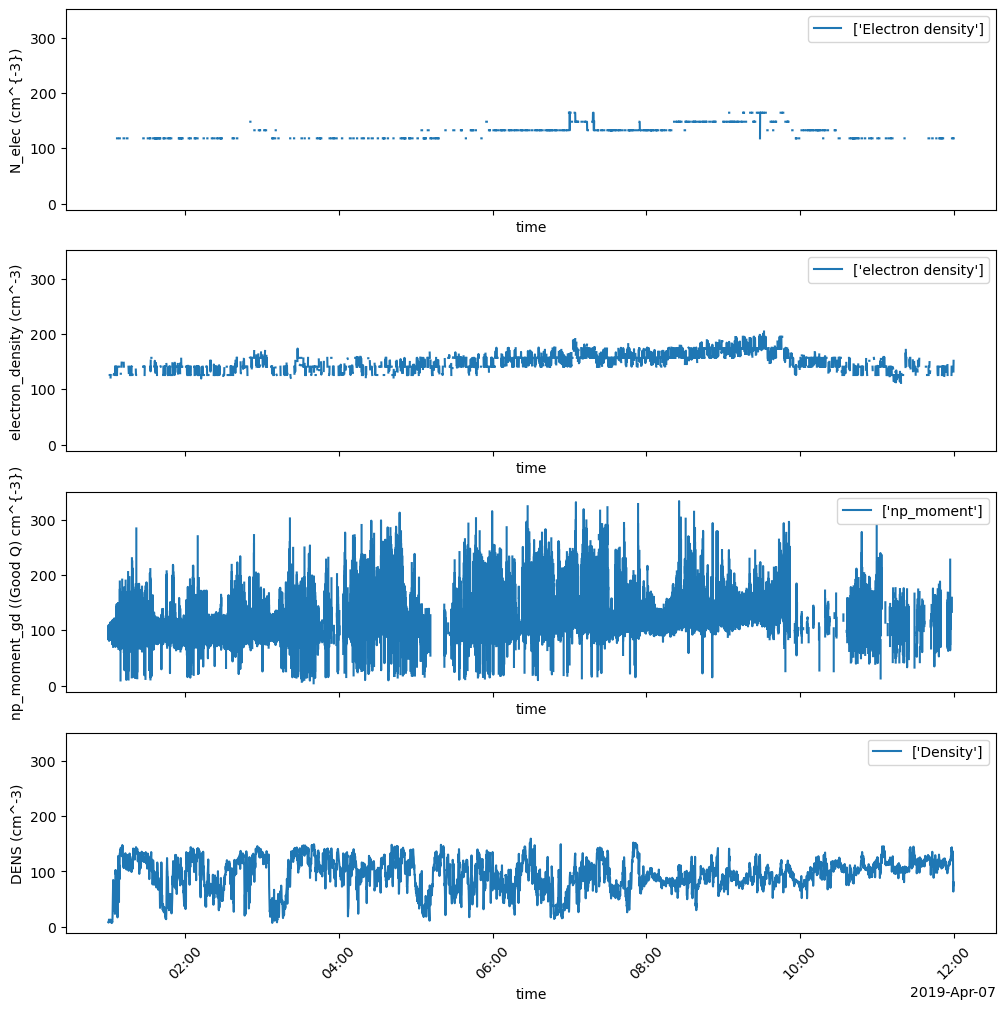

In [58]:
#| label: fig-data-products
from speasy import get_data, SpeasyVariable
import matplotlib.pyplot as plt
import polars as pl

products = [
    "cda/PSP_FLD_L3_RFS_LFR_QTN/N_elec",
    "cda/PSP_FLD_L3_SQTN_RFS_V1V2/electron_density",
    "cda/PSP_SWP_SPC_L3I/np_moment_gd",
    "cda/PSP_SWP_SPI_SF00_L3_MOM/DENS",
]


def plot(timerange, products: list[str]):
    data = get_data(products, timerange)

    data: list[SpeasyVariable]

    fig, axes = plt.subplots(ncols=1, nrows=len(data), sharey=True, sharex=True)

    for d, ax in zip(data, axes):
        d.replace_fillval_by_nan().plot(ax=ax)

    fig.set_size_inches(12, 12)
    return fig, axes


def check_time_resolution(timerange, products: list[str]):
    data = get_data(products, timerange)

    data: list[SpeasyVariable]

    for d in data:
        df = pl.from_dataframe(
            d.replace_fillval_by_nan()
            .to_dataframe()
            .reset_index()
            .rename(columns={"index": "time"})
        )
        
        info = df.with_columns(
            delta = pl.col("time").diff()
        ).describe()
        
        info_clean = df.drop_nulls().select(
            delta = pl.col("time").diff()
        ).describe()
        
        display(info.join(info_clean, on="statistic", suffix=" (clean)"))


plot(timerange, products)

check_time_resolution(timerange, products)

### Process

In [59]:
psp_ids_dataset = (
    get_and_process_data(mag_dataset, mag_parameters, timerange, tau, ts, p_vars=p_vars)
    .find_events()
    .update_candidates_with_plasma_data()
    .export(fname)
)

19-Feb-24 16:05:49: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [ ]:
psp_ids_dataset.plot(offset=timedelta(seconds=15))

In [15]:
ts = timedelta(seconds=1 / 11)
fname = f"{dir}/psp_ids_dataset_{enc}_{psp_p_instr}_r.{fmt}"


psp_ids_dataset_r = psp_ids_dataset.model_copy(deep=True)
psp_ids_dataset_r.data = resample(psp_ids_dataset_r.data, ts)
psp_ids_dataset_r.ts = ts
psp_ids_dataset_r.find_events().update_candidates_with_plasma_data().export(fname)

11-Feb-24 12:50:30: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=18650) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=18650) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=18650) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=18650) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=18650) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=186

Estimated completion of line 9:   0%           Elapsed time: 00:00, estimated remaining time: ?

IDsDataset(name=None, events=shape: (89, 107)
┌────────────┬───────┬───────────┬───────────┬───┬────────────┬───────────┬────────────┬───────────┐
│ time       ┆ count ┆ B_std     ┆ B_mean    ┆ … ┆ T.change   ┆ B.change  ┆ v.Alfven.c ┆ v.Alfven. │
│ ---        ┆ ---   ┆ ---       ┆ ---       ┆   ┆ ---        ┆ ---       ┆ hange      ┆ change.l  │
│ datetime[n ┆ u32   ┆ f64       ┆ f64       ┆   ┆ f64        ┆ f64       ┆ ---        ┆ ---       │
│ s]         ┆       ┆           ┆           ┆   ┆            ┆           ┆ f64        ┆ f64       │
╞════════════╪═══════╪═══════════╪═══════════╪═══╪════════════╪═══════════╪════════════╪═══════════╡
│ 2019-04-07 ┆ 176   ┆ 42.543101 ┆ 85.393798 ┆ … ┆ -20.301338 ┆ 0.083642  ┆ -141.27939 ┆ 317.01786 │
│ 01:05:28   ┆       ┆           ┆           ┆   ┆            ┆           ┆ 1          ┆ 6         │
│ 2019-04-07 ┆ 176   ┆ 37.298421 ┆ 85.808691 ┆ … ┆ 19.339516  ┆ 2.537321  ┆ 157.987252 ┆ -343.5237 │
│ 01:06:08   ┆       ┆           ┆           

## Wind dataset


In [16]:
ts = timedelta(seconds=1 / 11)
tau = timedelta(seconds=30)

mag_dataset = "WI_H2_MFI"
mag_parameters = ["BGSE"]

plasma_dataset="WI_PM_3DP"
plasma_parameters=["P_DENS", "P_VELS", "P_TEMP"] # Proton velocity vector (GSE)

# plasma_dataset="WI_K0_SWE"
# plasma_parameters=["Np", "V_GSM", "THERMAL_SPD"]

timerange = validate(earth_timerange)

fname = f"{dir}/wind_ids_dataset_{enc}.{fmt}"

In [ ]:

def get_and_process_data(
    mag_dataset,
    mag_parameters,
    timerange,
    tau,
    ts,
    p_vars: Variables = None,
    interpolate=True,
    every=timedelta(seconds=0.2),
):
    # define variables
    mag_vars = Variables(
        dataset=mag_dataset,
        parameters=mag_parameters,
        timerange=timerange,
    ).retrieve_data()

    p_vars.timerange = timerange
    p_vars.check_products()
    p_vars.retrieve_data()

    # get column names
    bcols = mag_vars.data[0].columns
    density_col = p_vars.data[0].columns[0]
    vec_cols = p_vars.data[1].columns
    temperature_col = p_vars.data[2].columns[0]

    # get data
    mag_data = mag_vars.to_polars().unique("time")
    plasma_data = (
        p_vars.to_polars()
        .with_columns(plasma_speed=pl_norm(vec_cols))
        .rename({density_col: "plasma_density"})
        .unique("time")
        # .drop_nulls()
    )
    # process temperature data
    if p_vars.data[2].unit == "km/s":
        plasma_data = plasma_data.pipe(df_thermal_spd2temp, temperature_col)
    else:
        plasma_data = plasma_data.rename({temperature_col: "plasma_temperature"})

    if interpolate:
        plasma_data = (
            plasma_data.with_columns(pl.col("plasma_density").fill_nan(None))
            .pipe(resample, every=every)
            .collect()
            .sort("time")
            .upsample("time", every=every)
            .interpolate()
            .lazy()
        )

    return IDsDataset(
        mag_data=mag_data,
        plasma_data=plasma_data,
        tau=tau,
        ts=ts,
        bcols=bcols,
        vec_cols=vec_cols,
        density_col="plasma_density",
        speed_col="plasma_speed",
        temperature_col="plasma_temperature",
    )

In [17]:
wind_ids_dataset = get_and_process_data(
    mag_dataset, mag_parameters, plasma_dataset, plasma_parameters, timerange, tau, ts
).find_events().update_candidates_with_plasma_data().export(fname)

11-Feb-24 12:50:50: Using pycdfpp
11-Feb-24 12:51:00: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [18]:
import hvplot.polars

In [19]:
wind_ids_dataset.plot()

2024-02-11 12:51:03.398 | INFO     | discontinuitypy.datasets:overview_plot:172 - Overview plot: 2020-01-29 23:40:15 - 2020-01-29 23:40:45
2024-02-11 12:51:03.398 | DEBUG    | discontinuitypy.datasets:log_event_change:79 - CHANGE INFO
        n.change: 0.4995388984680176
        v.ion.change: 7.461979130688064
        T.change: 0.236236572265625
        v.Alfven.change: -7.14332788724645
        v.ion.change.l: 0.392388073545078
        v.Alfven.change.l: 40.50811492639099
        


:Layout
   .Overlay.I   :Overlay
      .NdOverlay.I :NdOverlay   [B comp]
         :Curve   [time]   (B)
      .VLine.I     :VLine   [x,y]
      .VLine.II    :VLine   [x,y]
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [time]   (plasma_density)
      .Scatter.I :Scatter   [time]   (plasma_density)
      .VLine.I   :VLine   [x,y]
      .VLine.II  :VLine   [x,y]
   .Overlay.III :Overlay
      .NdOverlay.I :NdOverlay   [veloity comp]
         :Curve   [time]   (v)
      .VLine.I     :VLine   [x,y]
      .VLine.II    :VLine   [x,y]
   .Overlay.IV  :Overlay
      .Curve.I  :Curve   [time]   (plasma_temperature)
      .VLine.I  :VLine   [x,y]
      .VLine.II :VLine   [x,y]

In [ ]:
from bokeh.io import output_notebook
output_notebook()